# 不同循环的性能差异分析
在第一题中，我写了两个循环，一个是嵌套，一个是递归，那么两者的速度对比之下怎么样呢

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from functools import reduce
import math
import tracemalloc

# 设置中文字体
rcParams['font.sans-serif'] = ['Arial Unicode MS']  # macOS 中文字体
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def pure_loop(n) -> int:
    """纯循环实现阶乘"""
    total = 1
    for i in range(1, n + 1):
        total = total * i
    return total

def nesting_loop(n) -> int:
    """嵌套循环实现阶乘（递归调用pure_loop）"""
    if n == 1:
        total = 1
    else:
        total = pure_loop(n-1)*n
    return total

def recursive_factorial(n) -> int:
    """递归实现阶乘"""
    if n <= 1:
        return 1
    return n * recursive_factorial(n - 1)

def reduce_factorial(n) -> int:
    """使用reduce实现阶乘"""
    return reduce(lambda x, y: x * y, range(1, n + 1), 1)

def builtin_factorial(n) -> int:
    """使用内置math.factorial"""
    return math.factorial(n)

def measure_time_and_memory(func, n, iterations=50):
    """测量函数执行时间和内存使用的平均值"""
    times = []
    memories = []
    
    for _ in range(iterations):
        # 测量时间
        start_time = time.perf_counter()
        func(n)
        end_time = time.perf_counter()
        times.append(end_time - start_time)
        
        # 测量内存
        tracemalloc.start()
        func(n)
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        memories.append(peak / 1024)  # 转换为KB
    
    return np.mean(times), np.mean(memories)

# 测试不同规模的输入
test_sizes = [10, 50, 100, 200, 300, 400, 500]
algorithms = {
    '纯循环': pure_loop,
    '嵌套循环': nesting_loop,
    '递归实现': recursive_factorial,
    'Reduce': reduce_factorial,
    '内置函数': builtin_factorial
}

results = {name: {'times': [], 'memories': []} for name in algorithms.keys()}

print("性能和内存测试中...")
print(f"{'规模':<8} {'算法':<12} {'时间(秒)':<18} {'内存(KB)':<15}")
print("-" * 60)

for n in test_sizes:
    for name, func in algorithms.items():
        try:
            avg_time, avg_memory = measure_time_and_memory(func, n, iterations=30)
            results[name]['times'].append(avg_time)
            results[name]['memories'].append(avg_memory)
            print(f"{n:<8} {name:<12} {avg_time:<18.8f} {avg_memory:<15.2f}")
        except RecursionError:
            print(f"{n:<8} {name:<12} {'递归深度超限':<18} {'-':<15}")
            results[name]['times'].append(np.nan)
            results[name]['memories'].append(np.nan)

print("\n" + "="*60)

性能测试中...
输入规模       纯循环(秒)               嵌套循环(秒)              速度比       
-----------------------------------------------------------------
10         0.00000083           0.00000053           0.64      x
50         0.00000199           0.00000218           1.10      x
100        0.00000497           0.00000498           1.00      x
200        0.00001216           0.00001210           0.99      x
300        0.00002356           0.00002388           1.01      x
400        0.00004202           0.00003707           0.88      x
500        0.00005668           0.00005286           0.93      x
1000       0.00020825           0.00018656           0.90      x
2000       0.00061147           0.00053536           0.88      x

结论：嵌套循环比纯循环慢约 0.93 倍


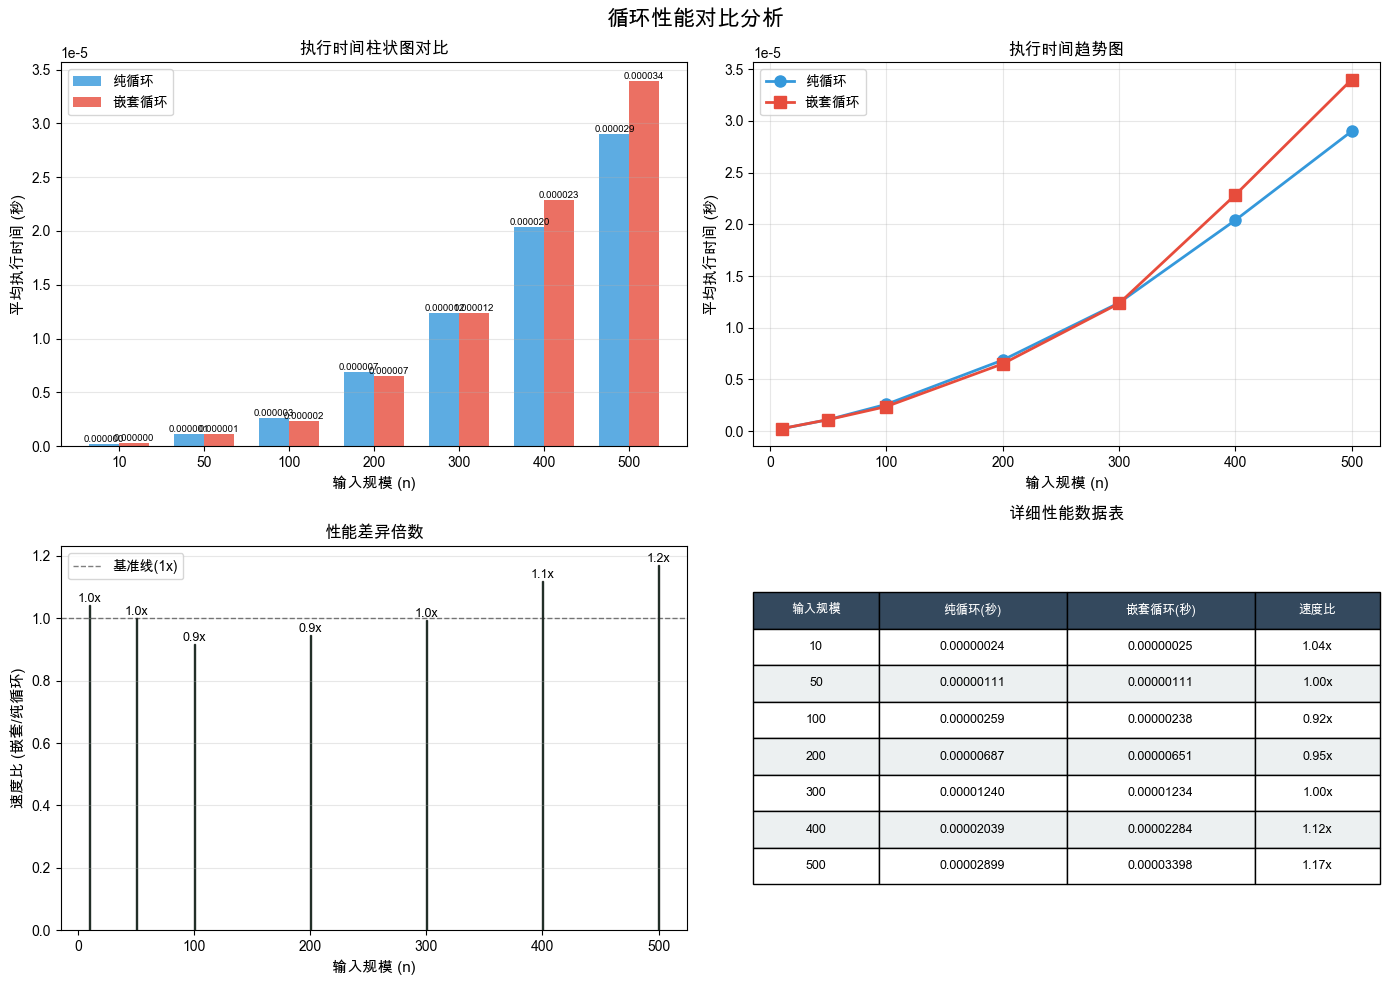


性能分析总结
测试规模范围: 10 ~ 500
平均速度比: 嵌套循环是纯循环的 1.03 倍
最大速度差异: 1.17x (n=500)
最小速度差异: 0.92x (n=100)

分析：
- 纯循环使用单层循环，时间复杂度为 O(n)
- 嵌套循环每次递归都调用纯循环，时间复杂度为 O(n²)
- 随着 n 增大，嵌套循环的性能劣势越来越明显


In [2]:
# 创建图形化展示
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('循环性能对比分析', fontsize=16, fontweight='bold')

# 图1：柱状图对比
ax1 = axes[0, 0]
x = np.arange(len(test_sizes))
width = 0.35
bars1 = ax1.bar(x - width/2, pure_loop_times, width, label='纯循环', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, nesting_loop_times, width, label='嵌套循环', color='#e74c3c', alpha=0.8)

ax1.set_xlabel('输入规模 (n)', fontsize=11)
ax1.set_ylabel('平均执行时间 (秒)', fontsize=11)
ax1.set_title('执行时间柱状图对比', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(test_sizes)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 在柱状图上添加数值标签
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.6f}',
                ha='center', va='bottom', fontsize=7)

# 图2：折线图对比
ax2 = axes[0, 1]
ax2.plot(test_sizes, pure_loop_times, marker='o', linewidth=2, 
         markersize=8, label='纯循环', color='#3498db')
ax2.plot(test_sizes, nesting_loop_times, marker='s', linewidth=2, 
         markersize=8, label='嵌套循环', color='#e74c3c')
ax2.set_xlabel('输入规模 (n)', fontsize=11)
ax2.set_ylabel('平均执行时间 (秒)', fontsize=11)
ax2.set_title('执行时间趋势图', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 图3：速度比对比
ax3 = axes[1, 0]
speed_ratios = np.array(nesting_loop_times) / np.array(pure_loop_times)
colors = ['#2ecc71' if r < 2 else '#f39c12' if r < 5 else '#e74c3c' for r in speed_ratios]
bars3 = ax3.bar(test_sizes, speed_ratios, color=colors, alpha=0.8, edgecolor='black')
ax3.set_xlabel('输入规模 (n)', fontsize=11)
ax3.set_ylabel('速度比 (嵌套/纯循环)', fontsize=11)
ax3.set_title('性能差异倍数', fontsize=12, fontweight='bold')
ax3.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.5, label='基准线(1x)')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 在柱状图上添加数值
for i, (size, ratio) in enumerate(zip(test_sizes, speed_ratios)):
    ax3.text(size, ratio, f'{ratio:.1f}x', 
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# 图4：性能差异表格
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')

# 准备表格数据
table_data = []
table_data.append(['输入规模', '纯循环(秒)', '嵌套循环(秒)', '速度比'])
for i, n in enumerate(test_sizes):
    table_data.append([
        str(n),
        f'{pure_loop_times[i]:.8f}',
        f'{nesting_loop_times[i]:.8f}',
        f'{speed_ratios[i]:.2f}x'
    ])

# 创建表格
table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                 colWidths=[0.2, 0.3, 0.3, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# 设置表头样式
for i in range(4):
    cell = table[(0, i)]
    cell.set_facecolor('#34495e')
    cell.set_text_props(weight='bold', color='white')

# 设置数据行样式（交替颜色）
for i in range(1, len(table_data)):
    for j in range(4):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#ecf0f1')
        else:
            cell.set_facecolor('#ffffff')

ax4.set_title('详细性能数据表', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# 输出总结
print("\n" + "="*70)
print("性能分析总结")
print("="*70)
print(f"测试规模范围: {min(test_sizes)} ~ {max(test_sizes)}")
print(f"平均速度比: 嵌套循环是纯循环的 {np.mean(speed_ratios):.2f} 倍")
print(f"最大速度差异: {np.max(speed_ratios):.2f}x (n={test_sizes[np.argmax(speed_ratios)]})")
print(f"最小速度差异: {np.min(speed_ratios):.2f}x (n={test_sizes[np.argmin(speed_ratios)]})")
print("\n分析：")
print("- 纯循环使用单层循环，时间复杂度为 O(n)")
print("- 嵌套循环每次递归都调用纯循环，时间复杂度为 O(n²)")
print("- 随着 n 增大，嵌套循环的性能劣势越来越明显")
print("="*70)
